<a href="https://colab.research.google.com/github/lokalov/lokalov_ML/blob/ITMO_ML/courses_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Локалов В.А. Задание 2

Добавление библиотек

In [2]:
!pip install --upgrade matplotlib > None # need refresh enviroment after installation


In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 10.2 MB/s eta 0:00:00


In [4]:
#pip install numpy
#pip install pandas

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:

from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [7]:

import shap

## Расширение набора данных для построения более сложной модели

Подключение датасета.

Более сложная модель будет брать из исходного датасета дополнительные поля, которые предположительно могут позволить повысить точность определения целевого показателя - ПРОГНОЗИРУЕМОГО ИНТЕРВАЛА ОБУЧЕНИЯ УЧАЩИХСЯ

In [8]:
path = 'https://github.com/lokalov/lokalov_ML/raw/main/datasetVAL.xlsx'
data = pd.read_excel(path, index_col='Unnamed: 0')

In [9]:
data.head()

,N,VOZR,GOD_POST,VREM_OB,COD_COURS,UROVEN,NAPR,UZNAL,VR_PUT,PROFROD,TEACHER,STAG
1,6561,13,2016,1,6,3,2,знакомые,32,инженер,150,0
2,6587,14,2016,8,13,3,4,интернет,15,инженер,140,1
3,6971,14,2016,8,13,3,4,интернет,5,заведующий,140,1
4,6984,16,2016,8,16,3,7,знакомые,33,преподаватель,7,13
5,7045,14,2016,8,11,2,5,знакомые,17,менеджер,144,0



*   N - идентификационный номер учащегося
*   VOZR - полных лет учащемуся
*   GOD_POST - год поступления на курс
*   VREM_OB - продолжительность обучения (в месяцах)Новый пункт
*   COD_COURS - код курса - коррелирует с относительной сложностью курса
*   UROVEN - степень специализации курса (1-2-3)
*   NAPR - код предметной области (напр. графика, web-дизайн и т.д)
*   UZNAL - источник информации о курсах
*   VR_PUT - примерное время на дорогу до курсов (мин)
*   PROFROD - профессия родителя (заказчика)
*   TEACHER - код преподавателя
*   STAG - стаж преподавателя (в годах на год поступления учащегося)








In [10]:
data.shape

(3759, 12)

## Обоснование необходимых изменений в исходном датасете для построения более сложной модели

Относительно низкое  качество исходной модели могло быть связано с  тем что
1. Не учитывались факторы, отражающие наличие заинтересованности ряда учащихся в изучении конкретного направления обучения (учитывалась только сложность курса) фактроры одного года (внутренняя мотивация). Поле NAPR
2. Не учитывались факторы, определяющие внешнее влияние на процесс обучения (знакомые, рекомендовавшие курсы), родители (Поля UZNAL, PROFROD).



Агрегирование данных

In [11]:
agg_func_selection = {'UZNAL':['first'],'PROFROD':['first'],'GOD_POST':['first','last'],'VOZR':['first'],'STAG': ['first','last'], 'UROVEN': ['first','last'],'NAPR': ['first','last']}

In [12]:
df=data.groupby(['N'], as_index= True).agg(agg_func_selection)

Заменяем абсолютные года на интервалы.
Убираем поступивших и закончивших в последнем году (в датасете не должно быть Незавершенных интервалов обучения).
Удаляем принципиально зависимые столбцы

In [13]:
INT = df.loc[:,('GOD_POST','last')]-df.loc[:,('GOD_POST','first')]
df['INT']=INT

In [14]:
GOD_MAX=df['GOD_POST','last'].max()
df=df.loc[(df['GOD_POST','first'] < GOD_MAX)&(df['GOD_POST','last']  < GOD_MAX)]
df=df.drop([('GOD_POST','last'),('GOD_POST','first')],axis=1)


In [15]:
df.head()

UZNAL        PROFROD  VOZR  STAG      UROVEN       NAPR      INT
         first          first first first last  first last first last    
N                                                                        
6561  знакомые        инженер    13     0    0      3    3     2    2   0
6587  интернет        инженер    14     1    1      3    3     4    4   0
6971  интернет     заведующий    14     1    1      3    3     4    4   0
6984  знакомые  преподаватель    16    13   13      3    3     7    7   0
7045  знакомые       менеджер    14     0    1      2    3     5    5   1

Анализ добавленных категориальных столбцов

In [16]:
a=pd.crosstab(index=df['PROFROD','first'], columns='count')
a.sort_values(by='count')


col_0,count
"(PROFROD, first)",
сотр_антей,1
ректор,1
режиссер,1
продюссер,1
провизор,1
...,...
преподаватель,67
менеджер,70
бухгалтер,72


В столбце PROFROD отсутствует 42% данных, 164 варианта профессий, нечетко сформулированы и с небольшими частотами. Данный столбец будет только зашумлять модель

In [17]:
df=df.drop([('PROFROD','first')],axis=1)

Столбец UZNAL

In [18]:

pd.crosstab(df['INT'],df['UZNAL','first'])


"(UZNAL, first)",вк,газета,дод,знакомые,интернет,итмо,н,родств,сайт_итмо,школа
INT,,,,,,,,,,
0,28,1,1,476,432,21,51,3,93,3
1,8,0,1,237,209,13,34,0,34,1
2,12,0,1,93,115,8,6,0,2,4
3,2,0,0,39,52,1,1,1,0,0
4,0,0,0,16,19,3,1,1,0,0
5,0,0,0,3,3,0,1,0,0,0


Поскольку значения UZNAL можноупорядочить по численности (можно интерпретировать как степень влияния источника), кодируем как порядковую шкалу

In [19]:
numeric_map = {'газета':1, 'дод':2, 'родств':3, 'школа':4,'итмо':5,'вк':6,'н':7,'сайт_итмо':9,'интернет':10,'знакомые':11}
df['UZNAL','first']=df['UZNAL','first'].replace(numeric_map)

Датасет для усложненной модели

In [20]:
df.head()

UZNAL  VOZR  STAG      UROVEN       NAPR      INT
     first first first last  first last first last    
N                                                     
6561    11    13     0    0      3    3     2    2   0
6587    10    14     1    1      3    3     4    4   0
6971    10    14     1    1      3    3     4    4   0
6984    11    16    13   13      3    3     7    7   0
7045    11    14     0    1      2    3     5    5   1

In [21]:
df.shape

(2030, 9)

# Дерево регрессии

Разбиение датасета на тренировочную и тестовую часть.


In [22]:
y=df['INT']
X=df.drop(['INT'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1030, test_size=0.25)

Построение дерева решений

In [23]:
dectree = DecisionTreeRegressor(max_depth=4)
dectree.fit(X_train,y_train)
dectree.score(X_test,y_test)
#коэффициент детерминации прогноза:

0.5722885933652908

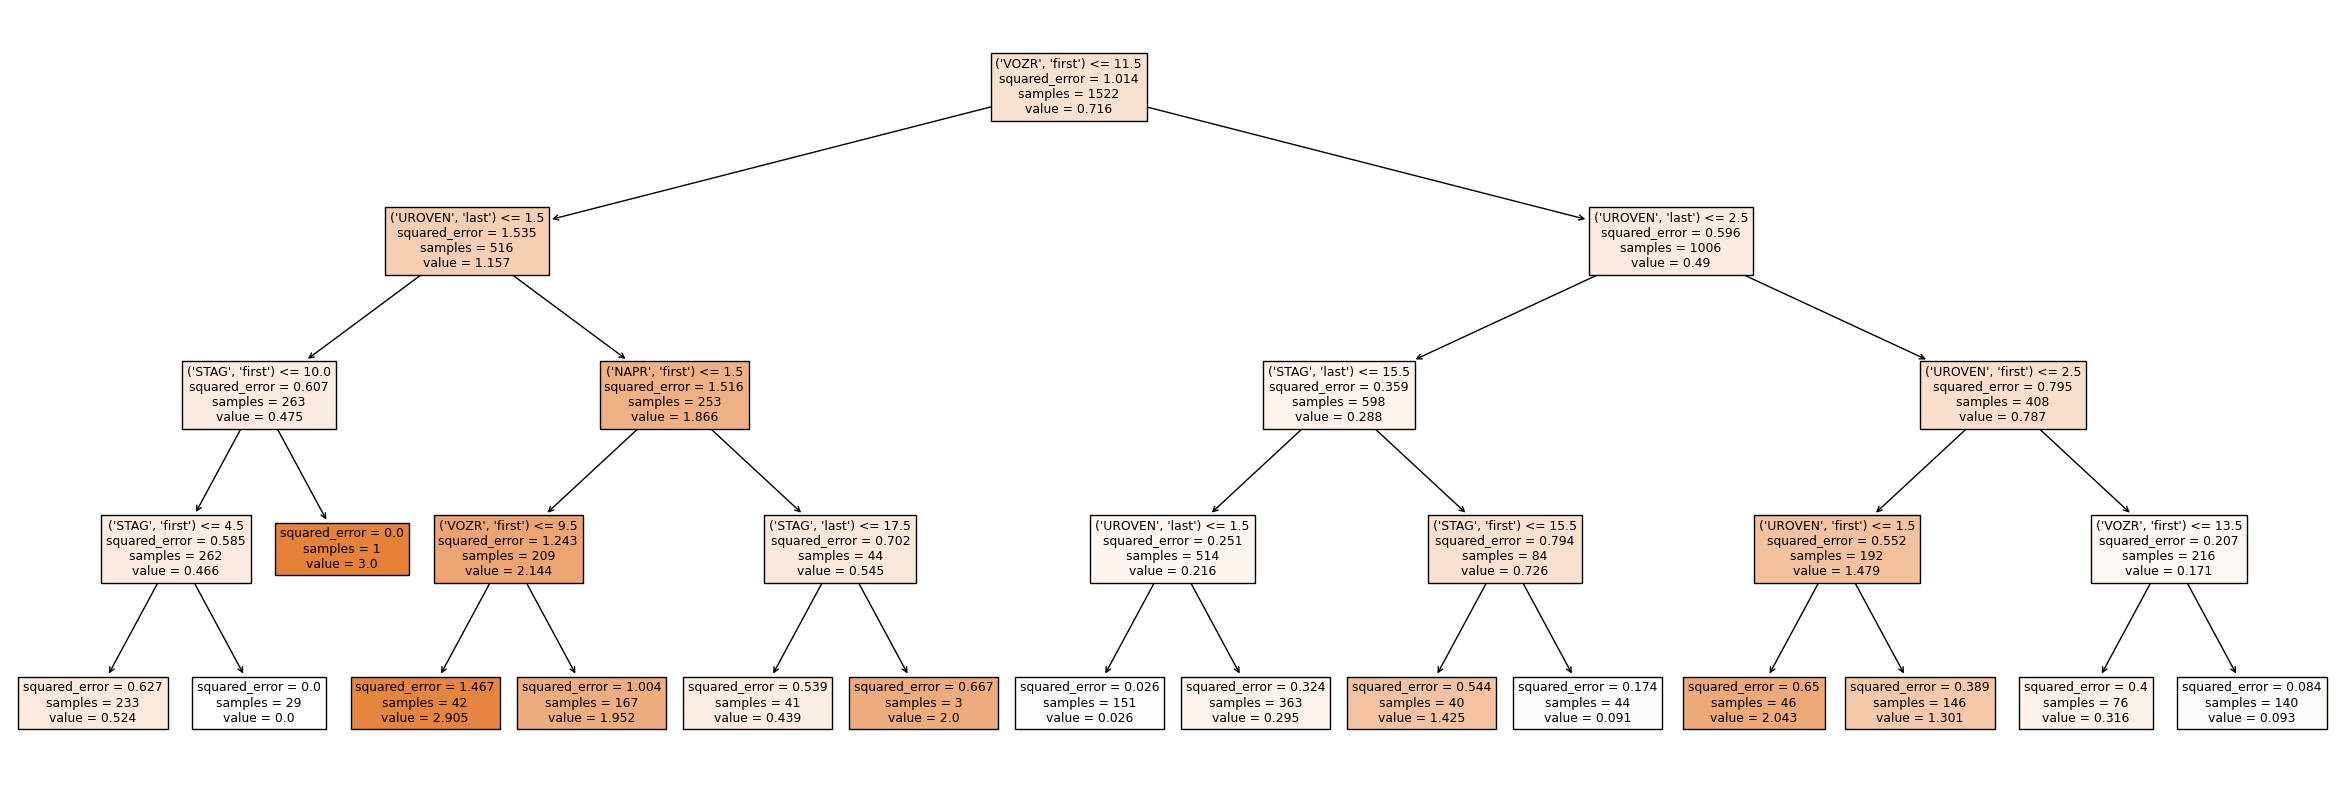

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=((30,10)))
plot_tree(dectree,
          filled=True,
          feature_names=X.columns)
plt.show()

# Случайный лес

In [25]:
rf = RandomForestRegressor(random_state=1030)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_preds, squared=True)}')

MSE: 0.3203231586187113


# Выбор гиперпараметров. Кроссвалидация

In [26]:
parameters = {
    'n_estimators': np.arange(3, 15, 3),
    'max_depth': list(range(3, 11)) + [None],
    'random_state': [1030],
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=parameters,
    n_jobs=2,
    verbose=1,
    cv=3,
)

GridSearchCV выбирает комбинацию гиперпараметров с помощью кроссвалидации.

In [27]:
%%time

grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
max_depth: 9
n_estimators: 12
random_state: 1030
CPU times: user 270 ms, sys: 94.5 ms, total: 364 ms
Wall time: 7.13 s


In [28]:
y_preds = grid_search.best_estimator_.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_preds, squared=True)}')

MSE: 0.3034825760931993


Сложная модель - более высокого качества по метрике MSE (было 0.46; стало 0.30)

# Визуализация и интерпретация

In [29]:
explainer = shap.TreeExplainer(rf)

In [30]:
a=X_test.loc[df['INT']==4]
a.head()

UZNAL  VOZR  STAG      UROVEN       NAPR     
      first first first last  first last first last
N                                                  
10599    11     9     1    5      1    3     1    2
10319    10     9     2   18      1    2     1    3
9345     10     9     1   11      1    3     1    5
10386    10    10     2    1      1    3     1    2
9674     11     9     0    4      1    3     1    2

In [31]:
choosen_instance = X_test.loc[[9345]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

Визуализирована проверка точности модели для строки данных.
Выборочная построчная проверка показала, что модель иногда выдает заниженные значения.

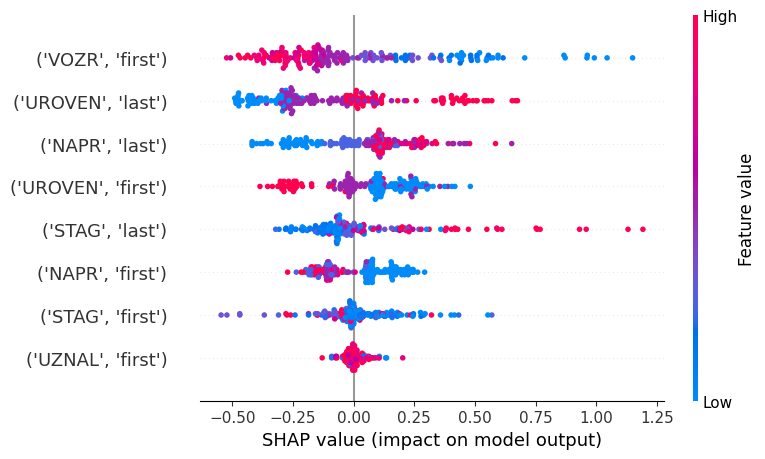

In [32]:
shap_values = explainer.shap_values(X_train.iloc[:200])
shap.summary_plot(shap_values, X_train.iloc[:200])

# Экспертное мнение

Диаграмма показывает, что наиболее сильное отрицательное влиянме на целевой показатель оказывает возраст поступления ('VOZRAST','first') и начальный уровень обучения ('UROVEN','first'). То есть, чем младше учащийся, чем ниже уровень специализации его курса, тем больше вероятность, что его интервал обучения будет ниже.
Модель таким образом адекватно отображает проблемы обучения на вводных курсах.
Модель также показывает возможность сильного отрицательного влияния выбора первого направления обучения.
На практике это возникает, когда направление не соответствует интересам учащегося.

Кроме того, дерево регрессии адекватно отображает стратегию решений, которую можно использовать для получения высокого целевого показателя при условии учета таких параметров как возраст поступления, направление обучения и стаж преподавателя.